In [1]:
!pip uninstall -y scikit-learn
!pip install -U scikit-learn


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 111.7 MB/s eta 0:00:00


In [2]:
import pandas as pd

df = pd.read_csv("customer_churn_data.csv")
df.head()



,CHURN,Gender,Status,Children,Est Income,Car Owner,Age,Paymethod,Usage,RatePlan
0,T,F,S,1,38000.00,N,24.393333,CC,229.64,3
1,F,M,M,2,29616.00,N,49.426667,CH,75.29,2
2,F,M,M,0,19732.80,N,50.673333,CC,47.25,3
3,F,M,S,2,96.33,N,56.473333,CC,59.01,1
4,F,F,M,2,52004.80,N,25.140000,CH,28.14,1


In [3]:
df.shape


(1799, 10)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CHURN       1799 non-null   object 
 1   Gender      1799 non-null   object 
 2   Status      1799 non-null   object 
 3   Children    1799 non-null   int64  
 4   Est Income  1799 non-null   float64
 5   Car Owner   1799 non-null   object 
 6   Age         1799 non-null   float64
 7   Paymethod   1799 non-null   object 
 8   Usage       1799 non-null   float64
 9   RatePlan    1799 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 140.7+ KB


In [5]:
df['CHURN'].value_counts()


,count
CHURN,
F,1076
T,723


In [6]:
df['CHURN'] = df['CHURN'].map({'T': 1, 'F': 0})


In [7]:
df['CHURN'].unique()


array([1, 0])

In [8]:
X = df.drop('CHURN', axis=1)
y = df['CHURN']


In [9]:
categorical_cols = ['Gender', 'Status', 'Car Owner', 'Paymethod']
numerical_cols = ['Children', 'Est Income', 'Age', 'Usage', 'RatePlan']


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


In [13]:
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [14]:
log_reg_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [15]:
y_pred_lr = log_reg_pipeline.predict(X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)



In [17]:

from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)


In [18]:
from sklearn.metrics import accuracy_score

print("LogReg:", accuracy_score(y_test, y_pred_lr))
print("Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Gradient Boosting:", accuracy_score(y_test, y_pred_gb))


LogReg: 0.725
Random Forest: 0.9805555555555555
Gradient Boosting: 0.925


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[210   5]
 [  2 143]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       215
           1       0.97      0.99      0.98       145

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



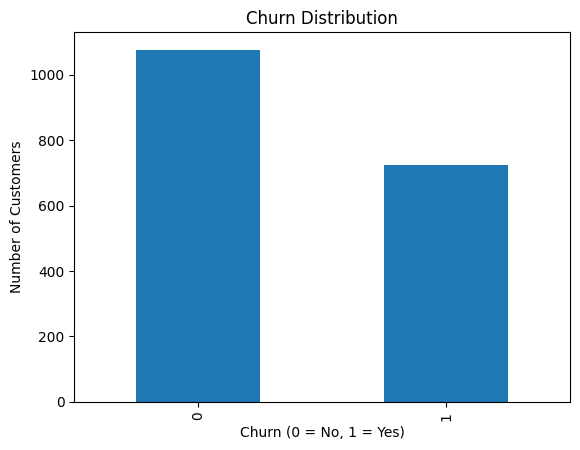

In [20]:
import matplotlib.pyplot as plt

df['CHURN'].value_counts().plot(kind='bar')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.title('Churn Distribution')
plt.show()


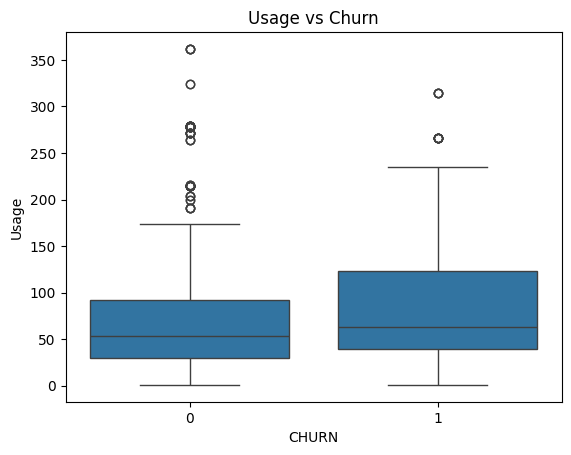

In [21]:
import seaborn as sns

sns.boxplot(x='CHURN', y='Usage', data=df)
plt.title('Usage vs Churn')
plt.show()


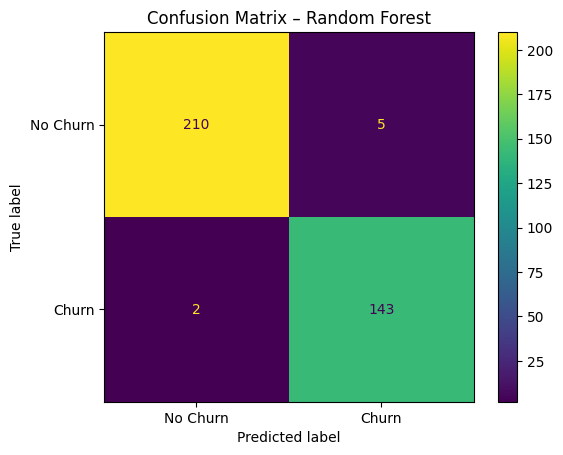

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=['No Churn', 'Churn']
)
plt.title('Confusion Matrix – Random Forest')
plt.show()


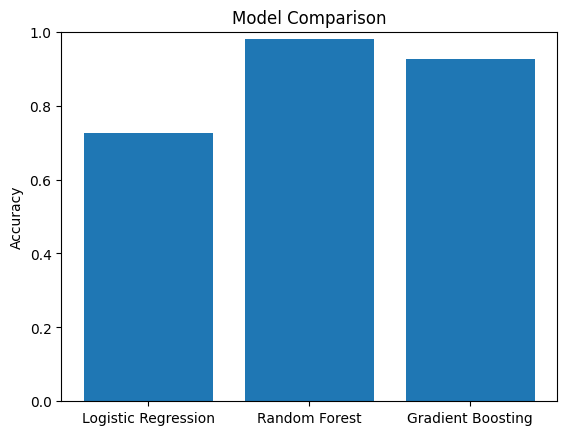

In [23]:
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [0.725, 0.981, 0.925]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()


In [24]:
import pandas as pd

# Get feature names after preprocessing
feature_names = (
    rf_pipeline.named_steps['preprocessor']
    .get_feature_names_out()
)

# Get feature importances from Random Forest
importances = (
    rf_pipeline.named_steps['classifier']
    .feature_importances_
)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)


,Feature,Importance
1,num__Est Income,0.227104
2,num__Age,0.190794
3,num__Usage,0.127742
0,num__Children,0.101128
7,cat__Status_S,0.082890
5,cat__Gender_M,0.075363
6,cat__Status_M,0.065835
4,num__RatePlan,0.052031
10,cat__Paymethod_CH,0.034287
9,cat__Paymethod_CC,0.022512


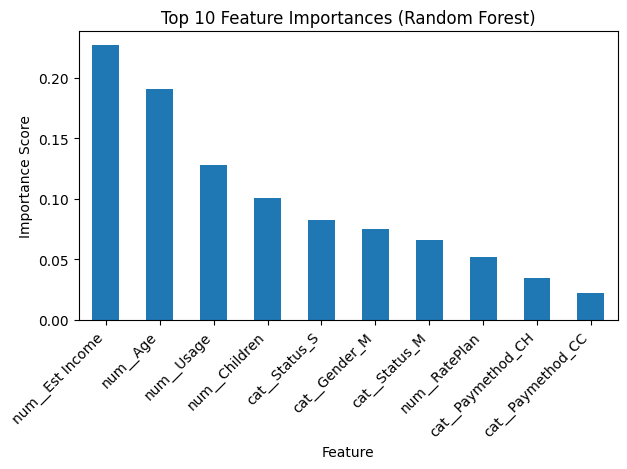

In [25]:

import matplotlib.pyplot as plt

feature_importance_df.head(10).plot(
    x='Feature',
    y='Importance',
    kind='bar',
    legend=False
)

plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [26]:
import joblib
joblib.dump(rf_pipeline, "customer_churn_random_forest.pkl")
from google.colab import files
files.download("customer_churn_random_forest.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>